In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 19.0 MB/s eta 0:00:00


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=625dea555bb7b1d7bbb211e45334ca79c8008dd56e9c9320ddc5660f9034cfe2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import lime
import lime.lime_tabular
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the NSL-KDD dataset
# Download NSL-KDD train dataset from: https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt'
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

df = pd.read_csv(url, header=None, names=columns)

In [ ]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [ ]:
# Print the categorical columns in the dataset
cat_df = df.select_dtypes(include=['object'])
print(cat_df.columns)

Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')


In [ ]:
# Encode categorical features
le = LabelEncoder()
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['service'] = le.fit_transform(df['service'])
df['flag'] = le.fit_transform(df['flag'])

In [ ]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)
df['label']

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: label, Length: 125973, dtype: int64

In [ ]:
# Split features and target
X = df.drop('label', axis=1)
y = le.fit_transform(df['label'])

In [ ]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,20
1,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,15
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,19
3,0,1,24,9,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,21
4,0,1,24,9,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,49,5,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1,20
125969,8,2,49,9,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0,21
125970,0,1,54,9,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0,18
125971,0,1,30,5,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,20


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Min-max normalization
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

In [ ]:
X_normalized

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty
0,0.000000,0.5,0.289855,0.9,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.952381
1,0.000000,1.0,0.637681,0.9,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.714286
2,0.000000,0.5,0.710145,0.5,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.904762
3,0.000000,0.5,0.347826,0.9,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1.000000
4,0.000000,0.5,0.347826,0.9,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.000000,0.5,0.710145,0.5,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.098039,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0.952381
125969,0.000186,1.0,0.710145,0.9,7.608895e-08,1.106923e-07,0.0,0.0,0.0,0.0,...,0.956863,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,1.000000
125970,0.000000,0.5,0.782609,0.9,1.616709e-06,2.931438e-07,0.0,0.0,0.0,0.0,...,0.117647,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0.857143
125971,0.000000,0.5,0.434783,0.5,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.031373,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.952381


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.20, random_state=42)

In [ ]:
# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Feature Importance (Tree-based)
importances = model.feature_importances_
feature_names = X.columns

In [ ]:
# Permutation Importance
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

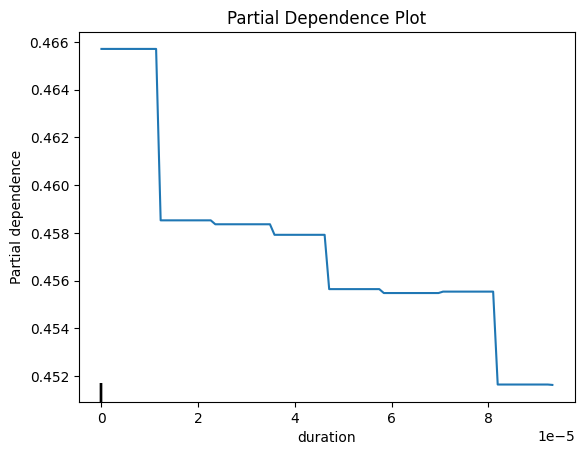

In [ ]:
# Partial Dependence Plot
PartialDependenceDisplay.from_estimator(model, X_train, features=[0], feature_names=feature_names)
plt.title('Partial Dependence Plot')
plt.show()

# Partial Dependence Plot (PDP)
PDPs show the marginal effect one or two features have on the predicted outcome of a machine learning model. It helps to understand how the prediction changes when a feature's value changes.


1.   The PDP plot shows how changes in the duration feature (feature index 0) affect the model's predictions.
2.   It shows the average prediction response as duration varies, holding all other features constant.
3.   A flat line would indicate the feature has little effect, while a varying line shows significant influence.




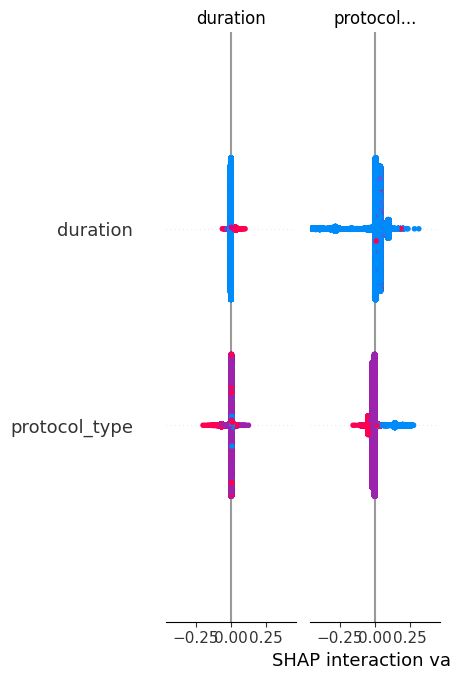

In [ ]:
# SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# SHAP Values
SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance and individual prediction explanations. They are based on cooperative game theory and offer both global and local interpretability.
1. The summary plot shows the impact of each feature on the model's output.
2. Each dot represents a SHAP value for a feature and a single instance.
3. The color represents the feature value (e.g., red for high values, blue for low values).
4. The position on the X-axis shows whether the effect of that value is associated with a higher or lower prediction.



In [ ]:
# LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=le.classes_, mode='classification')
exp = explainer.explain_instance(X_train.iloc[0].values, model.predict_proba, num_features=10)
exp.show_in_notebook(show_all=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# LIME
LIME (Local Interpretable Model-agnostic Explanations) provides local interpretability by approximating the model locally with an interpretable model like linear regression.
1. LIME explains the prediction of a single instance (first instance in this case).
2. It shows which features contributed most to the specific prediction.
3. This helps in understanding and debugging individual predictions.

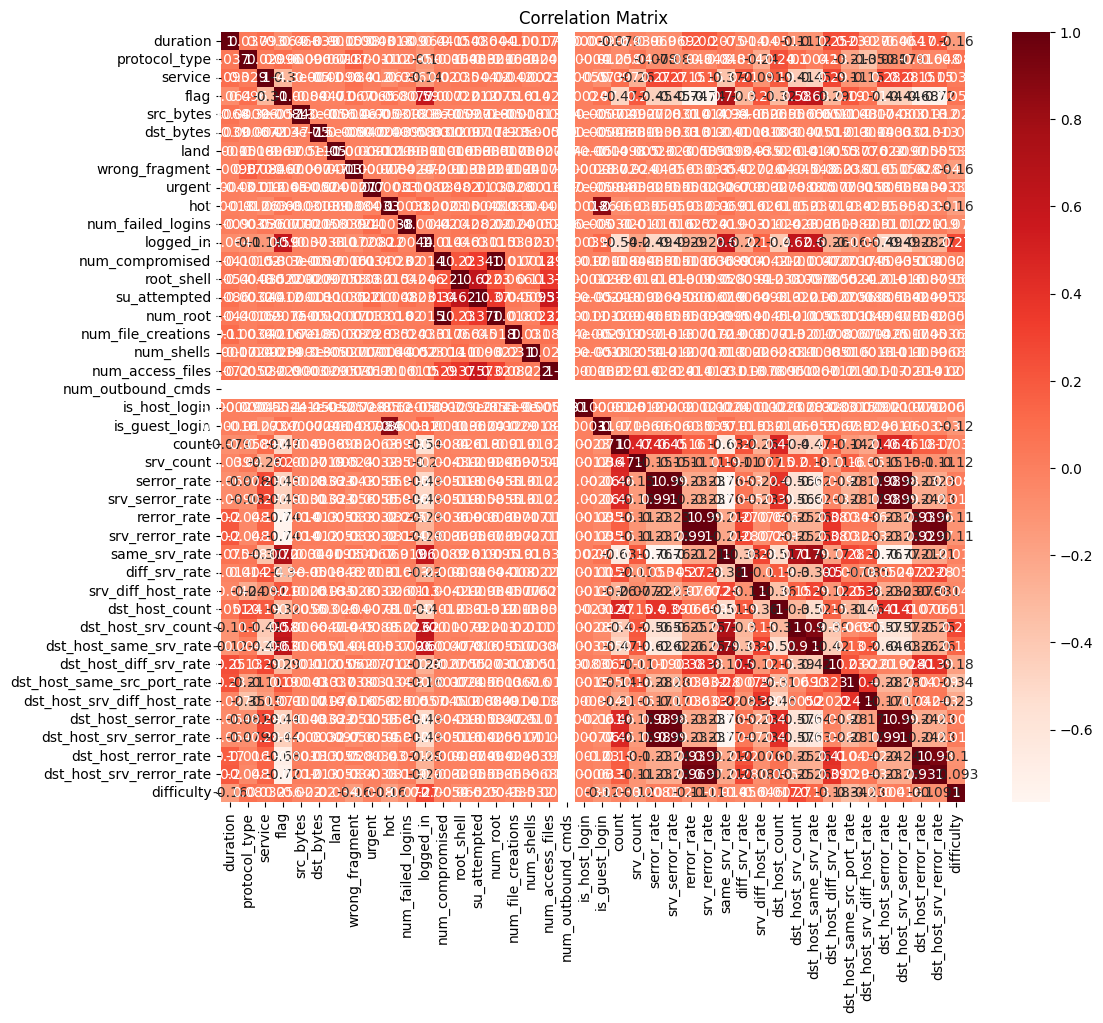

In [ ]:
# Correlation Matrix
corr_matrix = X_train.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Matrix')
plt.show()

# Correlation Matrix
The correlation matrix shows the pairwise correlation coefficients between features. This can reveal multicollinearity and relationships between features.
1. The heatmap shows correlation coefficients between features.
2. Values close to 1 or -1 indicate strong correlation, while values close to 0 indicate weak correlation.
3. Positive values indicate positive correlation, and negative values indicate negative correlation.



In [ ]:
# Feature Selection
selector = SelectKBest(f_classif, k=10)
selector.fit(X_train, y_train)
selected_features = selector.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_features]
print('Selected features:', selected_feature_names)

Selected features: ['flag', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# Feature Selection
SelectKBest selects the top k features based on statistical tests (ANOVA F-test in this case).
1. This output lists the top 10 features selected by the ANOVA F-test.
2. These features have the strongest relationship with the target variable based on the test.

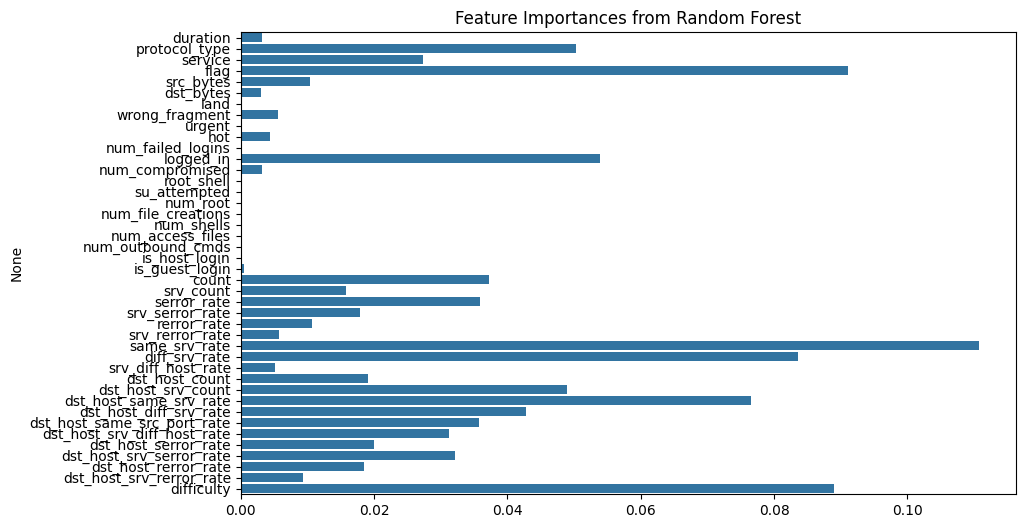

In [ ]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances from Random Forest')
plt.show()

# Feature Importance (Tree-based)
Tree-based feature importance provides a way to understand which features are most influential in making predictions. The RandomForest model computes this by looking at how much each feature reduces the impurity (e.g., Gini impurity) in the trees of the forest.

1.   The bar plot shows the importance of each feature. Higher bars indicate features that contribute more to the model's decisions.
2.   Features with higher importance scores have a larger impact on the model’s prediction.



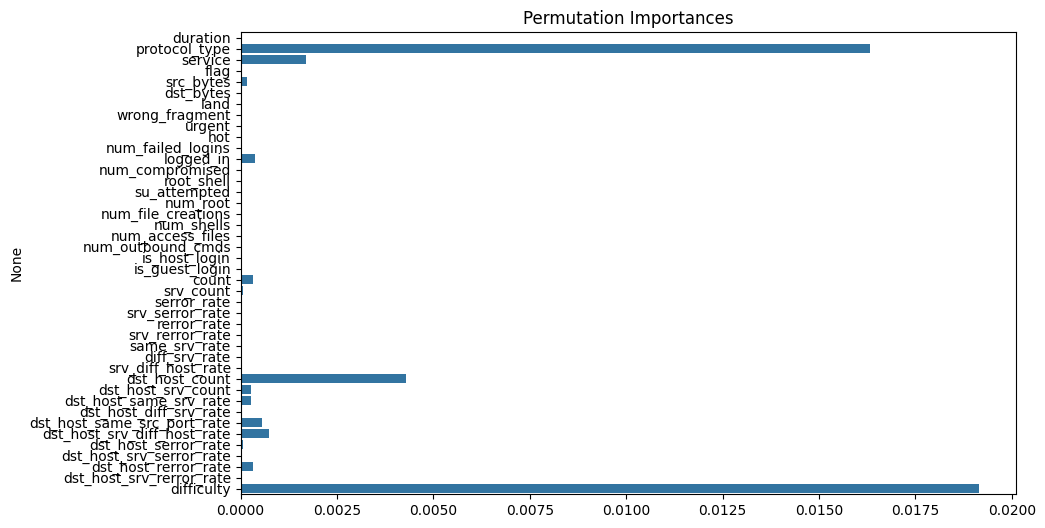

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_importance.importances_mean, y=feature_names)
plt.title('Permutation Importances')
plt.show()

# Permutation Importance
Permutation importance measures the change in the model's prediction error when the values of a feature are randomly shuffled. This process breaks the relationship between the feature and the target, and the increase in error indicates the importance of the feature.


1.   This bar plot shows the mean importance of each feature based on multiple permutations.
2.   Features with higher permutation importance scores indicate they are more critical for accurate predictions.

